# Finding an Edge to Win Jeopardy

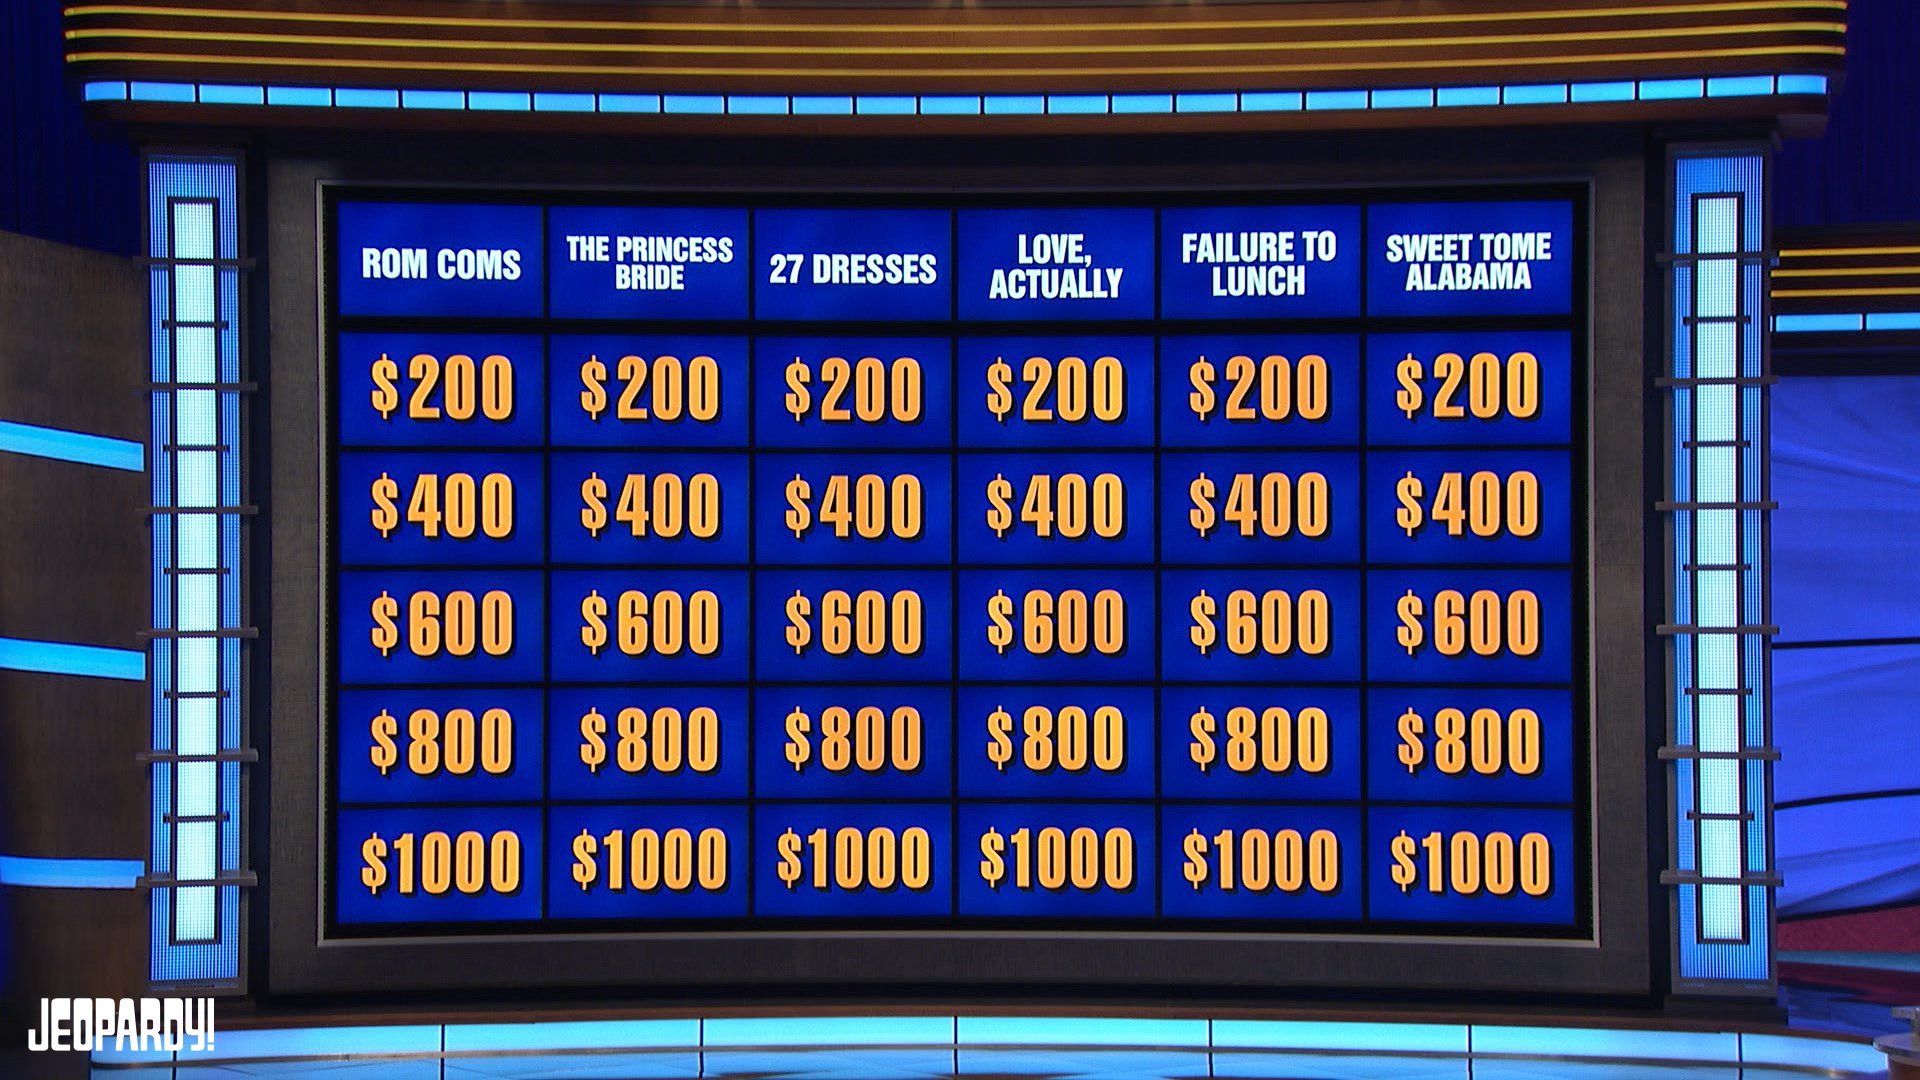

## Introduction
Jeopardy is a TV quiz show in the United States where participants compete to answer general knowledge questions for money.

Our task is to find patterns in a dataset of past Jeopardy questions in order to gain an edge in the competition.

The file can be downloaded [here](https://drive.google.com/file/d/0BwT5wj_P7BKXb2hfM3d2RHU1ckE/view?resourcekey=0-1abK4cJq-mqxFoSg86ieIg) as a JSON file.

### Conclusion
* The strategy of looking for the answer within a question itself is not worthwhile. Only 1% of (non-stop) words in questions will be included in the answer. 
* 91% of questions contain (significant) words that are repeated, however the top repeated words are mostly broad or ambiguous. This may be helpful if you were looking for broad topics of study, such as frequently talked about countries (America, Britain, England, France, Italy), but specific sub-topics within those categories aren't immediately clear.
* Our strategy of identifying for study frequently used, significantly higher value terms is not viable. We took the terms that were used more than 50 times and ran a chi-square test to determine which of those were used disproportiantely in either high or low categories. Of those that passed the significance threshold, all of them were disproportiantely used in lower value questions. Thinking about this logically, Jeopardy is likely to set low value questions as those that are more common knowledge, while the high value questions are those that are niche and less known. In this way the difficulty scales with the points at stake. 

In conclusion, the best viable strategy is to understand which broad topics are frequently asked and focus on gaining general knowledge there. This, however, is not a good strategy for someone looking to 'game' the game of Jeopardy.

## Data Exploration
Let's read in our dataset and gain a better understanding of its contents. 

In [1]:
import pandas as pd
import numpy as np
import re

jeopardy = pd.read_json('JEOPARDY_QUESTIONS1.json')

In [2]:
jeopardy.head()

,category,air_date,question,value,answer,round,show_number
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",$200,Copernicus,Jeopardy!,4680
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,$200,Jim Thorpe,Jeopardy!,4680
2,EVERYBODY TALKS ABOUT IT...,2004-12-31,'The city of Yuma in this state has a record a...,$200,Arizona,Jeopardy!,4680
3,THE COMPANY LINE,2004-12-31,"'In 1963, live on ""The Art Linkletter Show"", t...",$200,McDonald\'s,Jeopardy!,4680
4,EPITAPHS & TRIBUTES,2004-12-31,"'Signer of the Dec. of Indep., framer of the C...",$200,John Adams,Jeopardy!,4680


In [3]:
jeopardy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216930 entries, 0 to 216929
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   category     216930 non-null  object
 1   air_date     216930 non-null  object
 2   question     216930 non-null  object
 3   value        213296 non-null  object
 4   answer       216930 non-null  object
 5   round        216930 non-null  object
 6   show_number  216930 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 11.6+ MB


In [4]:
jeopardy['category'].value_counts().head(20)

BEFORE & AFTER             547
SCIENCE                    519
LITERATURE                 496
AMERICAN HISTORY           418
POTPOURRI                  401
WORLD HISTORY              377
WORD ORIGINS               371
COLLEGES & UNIVERSITIES    351
HISTORY                    349
SPORTS                     342
U.S. CITIES                339
WORLD GEOGRAPHY            338
BODIES OF WATER            327
ANIMALS                    324
STATE CAPITALS             314
BUSINESS & INDUSTRY        311
ISLANDS                    301
WORLD CAPITALS             300
U.S. GEOGRAPHY             299
RELIGION                   297
Name: category, dtype: int64

Our data consists of 7 columns with the following meaning:
* `category` - the category of the question
* `air_date` - the date the episode aired
* `question` - the text of the question
* `value` - the number of dollars the correct answer is worth
* `answer` - the text of the answer
* `round` - the round of Jeopardy
* `show_number` - the Jeopardy episode number

The columns are all string object types with the exception of `show_number` which is integer.

There are 216,930 rows of question data. The dataset has a high degree of completeness with the exception of the `value` column which hase slightly over 3,000 values missing.

## Data Preparation

### Normalizing Text in QA Columns
In order perform analysis on the content of the `question` and `answer` columns, we will need to normalize words with shared meaning into the same format. To do this we will need to change case and punctuation. 

In [5]:
pattern = ""

In [6]:
# function that takes in a string and normalizes it
def normalize_string(string):
    string = string.lower()
    
    # regex that keeps only alpha characters
    pattern = r"[^\w\s]" # any character except word or digit and space, tab, linebreak
    
    string = re.sub(pattern, "", string)
    
    return string

In [7]:
# show the before
print(jeopardy['question'].head(1))

0    'For the last 8 years of his life, Galileo was...
Name: question, dtype: object


In [8]:
# apply the functions and add columns
jeopardy['question_clean'] = jeopardy['question'].apply(normalize_string)
jeopardy['answer_clean'] = jeopardy['answer'].apply(normalize_string)

jeopardy['question_clean'].head()

0    for the last 8 years of his life galileo was u...
1    no 2 1912 olympian football star at carlisle i...
2    the city of yuma in this state has a record av...
3    in 1963 live on the art linkletter show this c...
4    signer of the dec of indep framer of the const...
Name: question_clean, dtype: object

### Converting Monetary Values to Integers
The value column is in string format. Let's remove unnecessary string elements and convert these to integers.  

In [9]:
jeopardy['value']

0          $200
1          $200
2          $200
3          $200
4          $200
          ...  
216925    $2000
216926    $2000
216927    $2000
216928    $2000
216929     None
Name: value, Length: 216930, dtype: object

The only string element we will need to remove is the dollar sign. There also appears to be None values that we will need to consider when we convert to numeric format.

In [10]:
# clean the string
def convert_int(string):
    try:
        string = string.replace("$", "")
        return int(string)
    
    except:
        return 0

In [11]:
# apply the function
jeopardy['value_clean'] = jeopardy['value'].apply(convert_int)

jeopardy['value_clean']

0          200
1          200
2          200
3          200
4          200
          ... 
216925    2000
216926    2000
216927    2000
216928    2000
216929       0
Name: value_clean, Length: 216930, dtype: int64

### Converting `air_date` to datetime
The `air_date` column is in string format, but we have more flexible analysis options if these were in datetime format.

In [12]:
jeopardy['air_date']

0         2004-12-31
1         2004-12-31
2         2004-12-31
3         2004-12-31
4         2004-12-31
             ...    
216925    2006-05-11
216926    2006-05-11
216927    2006-05-11
216928    2006-05-11
216929    2006-05-11
Name: air_date, Length: 216930, dtype: object

In [13]:
# convert to date_time
jeopardy['air_date'] = pd.to_datetime(jeopardy['air_date'])

In [14]:
jeopardy['air_date']

0        2004-12-31
1        2004-12-31
2        2004-12-31
3        2004-12-31
4        2004-12-31
            ...    
216925   2006-05-11
216926   2006-05-11
216927   2006-05-11
216928   2006-05-11
216929   2006-05-11
Name: air_date, Length: 216930, dtype: datetime64[ns]

### Removing Stopwords
Stop words are commonly used words such as "the", "a", "an", "in" that provide little value to meaning in a sentence. Let's remove these words from our questions and answers as they create noise in our results.

In [15]:
# import our list of stopwords
stopwords = pd.read_csv('stopwords.csv')
stopwords = list(stopwords['stopwords'])
stopwords

['a',
 'able',
 'about',
 'above',
 'abroad',
 'according',
 'accordingly',
 'across',
 'actually',
 'adj',
 'after',
 'afterwards',
 'again',
 'against',
 'ago',
 'ahead',
 "ain't",
 'all',
 'allow',
 'allows',
 'almost',
 'alone',
 'along',
 'alongside',
 'already',
 'also',
 'although',
 'always',
 'am',
 'amid',
 'amidst',
 'among',
 'amongst',
 'an',
 'and',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'apart',
 'appear',
 'appreciate',
 'appropriate',
 'are',
 "aren't",
 'around',
 'as',
 "a's",
 'aside',
 'ask',
 'asking',
 'associated',
 'at',
 'available',
 'away',
 'awfully',
 'b',
 'back',
 'backward',
 'backwards',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'begin',
 'behind',
 'being',
 'believe',
 'below',
 'beside',
 'besides',
 'best',
 'better',
 'between',
 'beyond',
 'both',
 'brief',
 'but',
 'by',
 'c',
 'came',
 'can',
 'cannot',
 'cant',
 "can't",

In [16]:
jeopardy['question_clean'].head()

0    for the last 8 years of his life galileo was u...
1    no 2 1912 olympian football star at carlisle i...
2    the city of yuma in this state has a record av...
3    in 1963 live on the art linkletter show this c...
4    signer of the dec of indep framer of the const...
Name: question_clean, dtype: object

In [17]:
# function that removes stopwords from senteces
def remove_stopwords(sentence):
    word_list = sentence.split()
    
    words_left = [word for word in word_list if word not in stopwords]
    
    sentence = ' '.join(words_left)
    return sentence

In [18]:
jeopardy['question_clean'] = jeopardy['question_clean'].apply(remove_stopwords)
jeopardy['answer_clean'] = jeopardy['answer_clean'].apply(remove_stopwords)

In [19]:
jeopardy['question_clean'].head()

0    8 years life galileo house arrest espousing ma...
1    2 1912 olympian football star carlisle indian ...
2    city yuma state record average 4055 hours suns...
3    1963 live art linkletter show company served b...
4    signer dec indep framer constitution mass pres...
Name: question_clean, dtype: object

## Identifying Areas of Study
In order to figure out whether to study past questions, study general knowledge, or not study at all, it would be helpful to figure out two things:
* How often the answer can be found within the question.
* How often questions are repeated.

### Answers Found Within Questions
Let's find out how often the answer to a question can be found within the question itself. 

In [20]:
# function that takes in question and answer and finds if there's a match between the words
def answer_in_question(row):
    # create lists of words
    split_answer = row[-2].split()
    split_question = row[-3].split()
    
    match_count = 0
    
    # if 'the' is in the answer, remove it. Common and unnecessary
    #new_split_answer = [word for word in split_answer if word != 'the']
    
    # validate to prevent division by zero
    if len(split_answer) == 0 or len(split_question) == 0:
        return 0
    else:
        pass
    
    # count the number of times a word appears in the question
    for word in split_answer:
        if word in split_question:
            match_count += 1
            
    words_in_answer_ratio = match_count/len(split_question)
    
    return words_in_answer_ratio
    

In [21]:
jeopardy['answer_in_question'] = jeopardy.apply(answer_in_question, axis = 1)

jeopardy.head()

,category,air_date,question,value,answer,round,show_number,question_clean,answer_clean,value_clean,answer_in_question
0,HISTORY,2004-12-31,"'For the last 8 years of his life, Galileo was...",$200,Copernicus,Jeopardy!,4680,8 years life galileo house arrest espousing ma...,copernicus,200,0.0
1,ESPN's TOP 10 ALL-TIME ATHLETES,2004-12-31,'No. 2: 1912 Olympian; football star at Carlis...,$200,Jim Thorpe,Jeopardy!,4680,2 1912 olympian football star carlisle indian ...,jim thorpe,200,0.0
2,EVERYBODY TALKS ABOUT IT...,2004-12-31,'The city of Yuma in this state has a record a...,$200,Arizona,Jeopardy!,4680,city yuma state record average 4055 hours suns...,arizona,200,0.0
3,THE COMPANY LINE,2004-12-31,"'In 1963, live on ""The Art Linkletter Show"", t...",$200,McDonald\'s,Jeopardy!,4680,1963 live art linkletter show company served b...,mcdonalds,200,0.0
4,EPITAPHS & TRIBUTES,2004-12-31,"'Signer of the Dec. of Indep., framer of the C...",$200,John Adams,Jeopardy!,4680,signer dec indep framer constitution mass pres...,john adams,200,0.0


In [22]:
jeopardy['answer_in_question'].value_counts()

0.000000    201330
0.125000      2386
0.111111      2316
0.142857      2156
0.100000      1678
             ...  
0.363636         1
0.074074         1
0.150000         1
0.800000         1
0.230769         1
Name: answer_in_question, Length: 62, dtype: int64

In [23]:
jeopardy['answer_in_question'].mean()

0.011056947199412304

1% of words in questions asked will be a part of the answer to the question. Not very helpful.
### Repeated Questions
We want to know what percent of questions asked are repeat questions or new questions. This will help us prioritize our study time.

We can identify repeated questions by seeing how often complex words (6 or more characters) reoccur in the dataset. Let's build a function that counts word occurences in a dictionary.

In [24]:
question_overlap = []
terms_used = set()

sorted_jeopardy = jeopardy.sort_values('air_date')

for index, row in sorted_jeopardy.iterrows():
    match_count = 0
    split_question = row['question_clean'].split(' ')
    
#     for word in split_question:
#         if len(word) < 6:
#             split_question.remove(word)
    
    # remove words less than 6 characters
    #split_question = [word for word in split_question if len(word) > 5]
    
    # check if a word is in a set, if yes increment, otherwise add
    for word in split_question:
        if word in terms_used:
            match_count += 1
        else:
            terms_used.add(word)

    # get the ratio as long as there is a match
    if len(split_question) > 0:
        match_count /= len(split_question)
        
    question_overlap.append(match_count)
    
jeopardy['question_overlap'] = question_overlap

jeopardy['question_overlap'].mean()

0.9137122446585912

We see that 91% of questions contain words that are repeats. Let's see if we can get more insight.

In [25]:
word_count = {}

def count_repeated_words(row):
    words = row['question_clean'].split()
    for word in words:
        if len(word) < 6:
            return
        else:
            pass
        
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1
            
    return 

In [26]:
jeopardy.apply(count_repeated_words, axis = 1)

0         None
1         None
2         None
3         None
4         None
          ... 
216925    None
216926    None
216927    None
216928    None
216929    None
Length: 216930, dtype: object

Our apply function resulted in the creation of a dictionary. Let's explore that add create a new df.

In [27]:
word_count

{'signer': 14,
 'winter': 93,
 '197172': 4,
 'record': 86,
 'housewares': 2,
 'companys': 117,
 'accutron': 1,
 'outlaw': 16,
 'murdered': 19,
 'traitor': 9,
 'coward': 4,
 'worthy': 6,
 'africas': 32,
 'lowest': 71,
 'temperature': 58,
 'edward': 141,
 'teller': 7,
 'geologic': 14,
 'kirschner': 1,
 'brothers': 163,
 'revolutionary': 68,
 'single': 92,
 'hrefhttpwwwjarchivecommedia20041231_dj_23mp3beyond': 1,
 'california': 217,
 'steven': 32,
 '19541955': 1,
 'shorter': 15,
 'hrefhttpwwwjarchivecommedia20041231_dj_26mp3ripped': 1,
 'todays': 16,
 'headlines': 14,
 'turtle': 10,
 'philadelphia': 55,
 'modern': 132,
 'hrefhttpwwwjarchivecommedia20041231_dj_25mp3somewhere': 1,
 'crosscountry': 7,
 'skiing': 14,
 'referred': 72,
 'hrefhttpwwwjarchivecommedia20041231_dj_24mp3500': 1,
 'objects': 31,
 'largest': 766,
 'kingdom': 58,
 'united': 116,
 'hrefhttpwwwjarchivecommedia20100706_j_22wmvtate': 1,
 'huggable': 1,
 'peaches': 2,
 'island': 568,
 '5letter': 110,
 'separating': 6,
 'grap

In [28]:
repeated_words = pd.DataFrame.from_dict(word_count, orient = 'index', columns = ['times_repeated'])

repeated_words.sort_values('times_repeated', ascending = False).head(30)

,times_repeated
called,1340
country,1065
french,957
famous,845
capital,796
american,790
president,782
largest,766
target_blankherea,748
target_blanksarah,729


This approach of focusing on repeated questions may not be helpful. Most of the top repeated words aren't proper nouns, and of those that are most are broad or ambiguous.

### Focusing on High Value vs Low Value Topics
If our focus is earning points in the game of Jeopardy it will be helpful to know the types of questions that are high value. We can figure this out using a chi-squared test. 

First, we will need to categorize our questions into two categories: low value and high value. High value will be questions valued over 800 points. 

In [29]:
# categorization function based on value
def value_categorization(row):
    if row['value_clean'] > 800:
        return 1
    else :
        return 0

In [30]:
# apply function to dataframe and create new column
jeopardy['high_value'] = jeopardy.apply(value_categorization, axis = 1)

With our rows now categorized, let's create another function that takes in a word and returns the count of high and low value questions the word occurs in. Our goal here is to create a set of tables. The first being our being like the below, where for each category we count the number of times a word is in a high value question or a low value question.  Let's build that now.

 word list  | High Value Count | Low Value Count
-----|-----|-----
Word 1|Word 1 High Count|Word 1 Low Count|
Word 2|Word 2 High Count|Word 2 Low Count
...|...|...
Word n|Word n High Count|Word n Low Count

In [31]:
def word_value(word):
    low_count = 0
    high_count = 0
    
    for i, row in jeopardy.iterrows():
        if word in row['question_clean'].split(" "):
            if row['high_value'] == 1:
                high_count += 1
            else:
                low_count += 1
                
    return high_count, low_count

Let's now randomly pick 10 words from our `terms_used` set that we created in a previous step and append them to a new list. Then we will apply our word_value function to a new list.

In [32]:
import random
# choose 10 random words
comparison_terms = random.sample(terms_used, k = 10)


observed_expected = []
# apply our function to each word
for word in comparison_terms:
    observed_expected.append(word_value(word))
# display the count of high and low value questions for each word    
observed_expected

[(0, 1),
 (0, 1),
 (0, 1),
 (16, 58),
 (0, 2),
 (1, 0),
 (3, 4),
 (1, 0),
 (0, 1),
 (0, 2)]

Now that we have the observed counts of high and low word values for a few terms we can compute the expected counts and the chi-squared value. The expected counts is calculated by first calculating two constants, the total count for high value words and the total count for low value words. Then, for each word we sum the total count occurance for the word. Finally, we calculate the total count of all words, which is found by adding together the totals of high value and low value words. This will result in another table that looks like the below.

 word list  | High Value Count | Low Value Count | (sum column)  
-----|-----|-----|----- 
Word 1|Word 1 High Count|Word 1 Low Count| Total Count Word 1  
Word 2|Word 2 High Count|Word 2 Low Count| Total Count Word 2  
...|...|...|...  
Word n|Word n High Count|Word n Low Count| Total Count Word n 
(sum row) | Total Count High Value | Total Count Low Value | Total Count All Words  

From here, we calculate the expected values for each of word in the low value count and high value count columns. This will look like the below.

 word list  | Expected High Value Count | Expected Low Value Count 
-----|-----|-----
Word 1|(Total Count Word 1 x Total Count High Value) / Total Count All Words   |(Total Count Word 1 x Total Count Low Value) / Total Count All Words 
Word 2|(Total Count Word 2 x Total Count High Value) / Total Count All Words   |(Total Count Word 2 x Total Count Low Value) / Total Count All Words 
...|...|...
Word n|(Total Count Word n x Total Count High Value) / Total Count All Words   |(Total Count Word n x Total Count Low Value) / Total Count All Words


Each cell represents the expected value for that word and value combination. 

After this we will calculate the chi-square by following the below steps.
* Subtract the expected value from the observed value for each cell.
* Square the difference.
* Divide the squared difference by the expected value.
* Repeat for all the observed and expected values and add up the values.

In [33]:
high_value_count = jeopardy[jeopardy['high_value'] == 1].shape[0]
low_value_count = jeopardy[jeopardy['high_value'] == 0].shape[0]

print(high_value_count)
print(low_value_count)

53029
163901


In [34]:
from scipy.stats import chisquare
import numpy as np

chi_squared = []

for s in observed_expected:
    high = s[0]
    low = s[1]
    total = high + low
    
    total_prop = total / jeopardy.shape[0]
    
    expected_high = high_value_count * total_prop
    expected_low = low_value_count * total_prop
    
    dof = (10 - 1)*(2-1)
    
    observed = np.array([s[0], s[1]])
    expected = np.array([expected_high, expected_low])
    chi_squared.append(chisquare(observed, expected))
    
                           
chi_squared

[Power_divergenceResult(statistic=0.3235428703912728, pvalue=0.5694862483821648),
 Power_divergenceResult(statistic=0.3235428703912728, pvalue=0.5694862483821648),
 Power_divergenceResult(statistic=0.3235428703912728, pvalue=0.5694862483821648),
 Power_divergenceResult(statistic=0.31943281316869954, pvalue=0.5719487029690409),
 Power_divergenceResult(statistic=0.6470857407825455, pvalue=0.4211565342143838),
 Power_divergenceResult(statistic=3.0907805163212583, pvalue=0.07873703216726466),
 Power_divergenceResult(statistic=1.2848157961645266, pvalue=0.25700553604012244),
 Power_divergenceResult(statistic=3.0907805163212583, pvalue=0.07873703216726466),
 Power_divergenceResult(statistic=0.3235428703912728, pvalue=0.5694862483821648),
 Power_divergenceResult(statistic=0.6470857407825455, pvalue=0.4211565342143838)]

Generally we require a pvalue of .05 or below in order to consider the results significant. One of our words is close, however, indicating that if we take an approach aside from random sampling we may find words that meet the threshold.

### Frequently Used High-Value Words
Let's increase our focus by narrowing our word choices to those frequently used.

In [35]:
frequently_used_over_50 = repeated_words.loc[repeated_words['times_repeated'] > 50]
frequently_used_over_50

,times_repeated
winter,93
record,86
companys,117
lowest,71
temperature,58
...,...
swedish,56
johnson,70
indians,55
clinton,54


We're left with a managable list of words with which we can rerun our function.

In [36]:
frequently_used_df = pd.DataFrame(columns=['word','high','low'])
# apply our function to each word

index = 0

for word in list(frequently_used_over_50.index):
    frequently_used_df.loc[index, 'word'] = (word)
    
    high_low_tup = word_value(word)
    
    frequently_used_df.loc[index, 'high'] = (high_low_tup[0])
    frequently_used_df.loc[index, 'low'] = (high_low_tup[1])
    index += 1

In [37]:
frequently_used_df

,word,high,low
0,winter,106,266
1,record,131,586
2,companys,67,260
3,lowest,37,126
4,temperature,40,145
...,...,...,...
652,swedish,61,97
653,johnson,63,190
654,indians,42,155
655,clinton,49,162


In [38]:
frequently_used_df['high'] = frequently_used_df['high'].astype(int)
frequently_used_df['low'] = frequently_used_df['low'].astype(int)

In [39]:
frequently_used_df['low'].dtype

dtype('int32')

In [40]:
frequently_used_df.iloc[:,1]

0      106
1      131
2       67
3       37
4       40
      ... 
652     61
653     63
654     42
655     49
656     50
Name: high, Length: 657, dtype: int32

In [41]:
frequently_used_df

,word,high,low
0,winter,106,266
1,record,131,586
2,companys,67,260
3,lowest,37,126
4,temperature,40,145
...,...,...,...
652,swedish,61,97
653,johnson,63,190
654,indians,42,155
655,clinton,49,162


In [42]:
def chi_square(row):
    high = row['high']
    low = row['low']
    
    total = high + low
    
    total_proportion = total / jeopardy.shape[0]
    
    expected_high = jeopardy[jeopardy['high_value'] == 1].shape[0] * total_proportion
    expected_low = jeopardy[jeopardy['high_value'] == 0].shape[0] * total_proportion
    
    observed = np.array([high, low])
    expected = np.array([expected_high, expected_low])
    
    chi_square, p_value = chisquare(observed, expected) 
    return expected_high, expected_low, chi_square, p_value   

In [43]:
results = frequently_used_df.apply(chi_square, axis = 1)
results_df = pd.DataFrame(list(results), columns = ['expected_high', 'expected_low', 'chi_square','p_value'])
results_df

,expected_high,expected_low,chi_square,p_value
0,90.936191,281.063809,3.302713,0.069166
1,175.272175,541.727825,14.800854,0.000119
2,79.935846,247.064154,2.770678,0.096005
3,39.845697,123.154303,0.268989,0.604011
4,45.223644,139.776356,0.798582,0.371518
...,...,...,...,...
652,38.623436,119.376564,17.158286,0.000034
653,61.846388,191.153612,0.028480,0.865985
654,48.157069,148.842931,1.041900,0.307380
655,51.579399,159.420601,0.170726,0.679468


In [44]:
frequently_used_df = frequently_used_df.merge(results_df, left_index = True, right_index = True)

In [45]:
frequently_used_df

,word,high,low,expected_high,expected_low,chi_square,p_value
0,winter,106,266,90.936191,281.063809,3.302713,0.069166
1,record,131,586,175.272175,541.727825,14.800854,0.000119
2,companys,67,260,79.935846,247.064154,2.770678,0.096005
3,lowest,37,126,39.845697,123.154303,0.268989,0.604011
4,temperature,40,145,45.223644,139.776356,0.798582,0.371518
...,...,...,...,...,...,...,...
652,swedish,61,97,38.623436,119.376564,17.158286,0.000034
653,johnson,63,190,61.846388,191.153612,0.028480,0.865985
654,indians,42,155,48.157069,148.842931,1.041900,0.307380
655,clinton,49,162,51.579399,159.420601,0.170726,0.679468


In [46]:
significant_fu = frequently_used_df[(frequently_used_df['p_value'] <= .05)]
significant_fu.sort_values('chi_square', ascending=False).head(20)

,word,high,low,expected_high,expected_low,chi_square,p_value
23,target_blankthisa,727,889,395.034638,1220.965362,369.222686,2.763376e-82
323,target_blankherea,960,1479,596.218739,1842.781261,293.773786,7.486874e-66
65,target_blankjimmy,323,351,164.760734,509.239266,201.146655,1.173842e-45
66,target_blanksarah,323,406,178.205601,550.794399,155.711321,9.789275e-36
122,reports,488,741,300.431665,928.568335,154.992741,1.405336e-35
78,target_blankkelly,229,260,119.537090,369.462910,132.668955,1.068178e-30
67,target_blankjon,171,184,86.780505,268.219495,108.178537,2.456252e-25
74,french,816,1626,596.952095,1845.047905,106.384104,6.074304e-25
118,target_blankcheryl,190,222,100.714276,311.285724,104.763746,1.376021e-24
153,author,564,1114,410.190670,1267.809330,76.333926,2.395333e-18


In [47]:
print("Of our frequently used words,",len(frequently_used_df[(frequently_used_df['expected_high'] < frequently_used_df['expected_low'])]), "have a statistically significant higher use in low value questions.")
print("Of our frequently used words,",len(frequently_used_df[(frequently_used_df['expected_high'] > frequently_used_df['expected_low'])]), "have a statistically significant higher use in high value questions.")

Of our frequently used words, 657 have a statistically significant higher use in low value questions.
Of our frequently used words, 0 have a statistically significant higher use in high value questions.


Our strategy of identifying for study frequently used, significantly higher value terms is not viable. We took the terms that were used more than 50 times and ran a chi-square test to determine which of those were used disproportiantely in either high or low categories. Of those that passed the significance threshold, all of them were disproportiantely used in lower value questions. Thinking about this logically, Jeopardy is likely to set low value questions as those that are more common knowledge, while the high value questions are those that are niche and less known. In this way the difficulty scales with the points at stake. 

One strategy could be to go for the low value questions, however because there are so many topics in this bucket there is not a clear starting point.

## Conclusion
* The strategy of looking for the answer within a question itself is not worthwhile. Only 1% of (non-stop) words in questions will be included in the answer. 
* 91% of questions contain (significant) words that are repeated, however the top repeated words are mostly broad or ambiguous. This may be helpful if you were looking for broad topics of study, such as frequently talked about countries (America, Britain, England, France, Italy), but specific sub-topics within those categories aren't immediately clear.
* Our strategy of identifying for study frequently used, significantly higher value terms is not viable. We took the terms that were used more than 50 times and ran a chi-square test to determine which of those were used disproportiantely in either high or low categories. Of those that passed the significance threshold, all of them were disproportiantely used in lower value questions. Thinking about this logically, Jeopardy is likely to set low value questions as those that are more common knowledge, while the high value questions are those that are niche and less known. In this way the difficulty scales with the points at stake. 

In conclusion, the best viable strategy is to understand which broad topics are frequently asked and focus on gaining general knowledge there. This, however, is not a good strategy for someone looking to 'game' the game of Jeopardy.